# Llama 3.2 1B LoRA Fine-tuning - Local Setup

This notebook trains a LoRA (Low-Rank Adaptation) model on Llama 3.2 1B using your local machine.

## Prerequisites

1. **GPU**: NVIDIA GPU with CUDA support (recommended for faster training)
2. **RAM**: At least 8GB of system RAM
3. **Storage**: ~10GB free space for models and data
4. **Hugging Face Account**: For model access

## Setup Instructions

1. **Hugging Face Token**: 
   - Get your token from https://huggingface.co/settings/tokens
   - Set it as environment variable: `set HF_TOKEN=your_token_here` (Windows)
   - Or replace the token directly in the authentication cell

2. **Data File**: 
   - Ensure `combined_human_conversations.csv` is in your Documents folder
   - Or update the file path in the data loading cell

3. **Run cells in order** - the first cell will install all required packages

## What this notebook does

- Fine-tunes Llama 3.2 1B Instruct model using LoRA
- Uses 4-bit quantization to reduce memory usage
- Trains on conversational data in "Human 1/Human 2" format
- Saves the trained adapter for later use

In [2]:
# Local Environment Setup for Llama 3.2 LoRA Training
# Install required packages for local training

import sys
import subprocess

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to install {package}: {e}")

# Required packages for LoRA training
packages = [
    "transformers[sentencepiece]",
    "accelerate", 
    "peft",
    "bitsandbytes",
    "datasets",
    "trl",
    "torch",
    "pandas",
    "huggingface_hub",
    "python-dotenv",  # For loading .env files
    "flash-attn --no-build-isolation"  # Flash Attention for faster training (optional)
]

print("🔧 Installing required packages for local LoRA training...")
print("This may take a few minutes...")

for package in packages:
    if "flash-attn" in package:
        print("⚡ Installing Flash Attention (may take longer)...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "flash-attn", "--no-build-isolation"])
            print("✅ flash-attn installed successfully")
        except subprocess.CalledProcessError:
            print("⚠️ Flash Attention installation failed (optional - training will still work)")
    else:
        install_package(package)

print("\n🎉 Package installation complete!")
print("📝 Don't forget to create a .env file with your HF_TOKEN:")
print("   HF_TOKEN=your_hugging_face_token_here")
print("\n💡 Tips for GPU usage:")
print("   - Ensure CUDA drivers are up to date")
print("   - Close other GPU-intensive applications")
print("   - Monitor GPU memory usage during training")

🔧 Installing required packages for local LoRA training...
This may take a few minutes...
✅ transformers[sentencepiece] installed successfully
✅ transformers[sentencepiece] installed successfully
✅ accelerate installed successfully
✅ accelerate installed successfully
✅ peft installed successfully
✅ peft installed successfully
✅ bitsandbytes installed successfully
✅ bitsandbytes installed successfully
✅ datasets installed successfully
✅ datasets installed successfully
✅ trl installed successfully
✅ trl installed successfully
✅ torch installed successfully
✅ torch installed successfully
✅ pandas installed successfully
✅ pandas installed successfully
✅ huggingface_hub installed successfully
✅ huggingface_hub installed successfully
✅ python-dotenv installed successfully
⚡ Installing Flash Attention (may take longer)...
✅ python-dotenv installed successfully
⚡ Installing Flash Attention (may take longer)...
⚠️ Flash Attention installation failed (optional - training will still work)

🎉 Packa

In [3]:
# Local Hugging Face Authentication
# Option 1: Set your token as an environment variable HF_TOKEN
# Option 2: Replace 'YOUR_HF_TOKEN_HERE' with your actual token
# Option 3: Use huggingface_hub.notebook_login() for interactive login

# GPU Detection and Environment Setup
import torch
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

print("🔍 COMPREHENSIVE GPU & CUDA DETECTION")
print("=" * 50)

# 1. Basic PyTorch and CUDA check
print("1️⃣ PyTorch Installation:")
print(f"   PyTorch version: {torch.__version__}")
print(f"   PyTorch file location: {torch.__file__}")

# 2. CUDA Availability Check
print("\n2️⃣ CUDA Availability:")
cuda_available = torch.cuda.is_available()
print(f"   CUDA available: {cuda_available}")

if cuda_available:
    print(f"   CUDA version (PyTorch): {torch.version.cuda}")
    print(f"   cuDNN version: {torch.backends.cudnn.version()}")
    print(f"   cuDNN enabled: {torch.backends.cudnn.enabled}")
    
    # 3. GPU Information
    print("\n3️⃣ GPU Information:")
    gpu_count = torch.cuda.device_count()
    print(f"   GPU count: {gpu_count}")
    
    for i in range(gpu_count):
        props = torch.cuda.get_device_properties(i)
        memory_gb = props.total_memory / (1024**3)
        print(f"   GPU {i}: {props.name}")
        print(f"   Memory: {memory_gb:.1f} GB")
        print(f"   Compute capability: {props.major}.{props.minor}")
    
    # 4. Set up GPU device
    device = torch.device("cuda")
    print(f"\n4️⃣ Selected device: {device}")
    
    # 5. GPU Memory Management
    torch.cuda.empty_cache()
    if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
        torch.cuda.set_per_process_memory_fraction(0.9)
        print("   ✅ GPU memory fraction set to 90%")
    
    # 6. Test GPU functionality
    print("\n5️⃣ GPU Functionality Test:")
    try:
        # Simple tensor operation test
        test_tensor = torch.randn(100, 100).cuda()
        result = torch.matmul(test_tensor, test_tensor.T)
        print("   ✅ GPU tensor operations working correctly")
        
        # Memory info
        allocated = torch.cuda.memory_allocated() / (1024**3)
        reserved = torch.cuda.memory_reserved() / (1024**3)
        print(f"   GPU Memory - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
        
    except Exception as e:
        print(f"   ❌ GPU test failed: {e}")
        device = torch.device("cpu")
        print("   Falling back to CPU")

else:
    print("\n❌ CUDA NOT AVAILABLE!")
    print("Possible reasons:")
    print("   1. PyTorch CPU version installed instead of CUDA version")
    print("   2. NVIDIA drivers not installed or outdated")
    print("   3. CUDA toolkit not installed")
    print("   4. GPU not CUDA-compatible")
    print("\n💡 Solutions:")
    print("   1. Run the PyTorch CUDA installation cell below")
    print("   2. Update NVIDIA drivers")
    print("   3. Restart kernel after installation")
    
    device = torch.device("cpu")
    print(f"\n📍 Using device: {device}")

# Hugging Face Authentication from .env file
print("\n" + "=" * 50)
print("🔐 HUGGING FACE AUTHENTICATION")

hf_token = os.getenv('HF_TOKEN')

if hf_token:
    try:
        login(token=hf_token)
        print("✅ Successfully logged in to Hugging Face")
    except Exception as e:
        print(f"❌ HF login failed: {e}")
else:
    print("❌ No HF_TOKEN found in .env file!")
    print("Please create a .env file in your project directory with:")
    print("HF_TOKEN=your_token_here")

# Global device variable for use in other cells
DEVICE = device
print(f"\n🎯 FINAL SETUP - Training will use: {DEVICE}")
print("=" * 50)

if str(device) == "cpu":
    print("⚠️  WARNING: Training on CPU will be VERY slow!")
    print("   Consider fixing CUDA setup for much faster training")
else:
    print("🚀 Ready for GPU-accelerated training!")

🔍 COMPREHENSIVE GPU & CUDA DETECTION
1️⃣ PyTorch Installation:
   PyTorch version: 2.5.1+cu121
   PyTorch file location: C:\Users\rahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\__init__.py

2️⃣ CUDA Availability:
   CUDA available: True
   CUDA version (PyTorch): 12.1
   cuDNN version: 90100
   cuDNN enabled: True

3️⃣ GPU Information:
   GPU count: 1
   GPU 0: NVIDIA GeForce RTX 4060
   Memory: 8.0 GB
   Compute capability: 8.9

4️⃣ Selected device: cuda
   ✅ GPU memory fraction set to 90%

5️⃣ GPU Functionality Test:
   ✅ GPU tensor operations working correctly
   GPU Memory - Allocated: 0.01 GB, Reserved: 0.02 GB

🔐 HUGGING FACE AUTHENTICATION


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✅ Successfully logged in to Hugging Face

🎯 FINAL SETUP - Training will use: cuda
🚀 Ready for GPU-accelerated training!


In [21]:
# 🚀 RTX 4060 Optimized Configuration
print("🎯 RTX 4060 OPTIMIZATION SETTINGS")
print("=" * 50)

# RTX 4060 Specific Settings
RTX_4060_MEMORY = 8.0  # GB
AVAILABLE_MEMORY = RTX_4060_MEMORY * 0.85  # Use 85% to leave room for system

print(f"🔧 Optimizing for RTX 4060:")
print(f"   Total VRAM: {RTX_4060_MEMORY} GB")
print(f"   Available for training: {AVAILABLE_MEMORY:.1f} GB")
print(f"   Compute Capability: 8.9 (Ada Lovelace)")

# RTX 4060 Optimal Settings
print("⚙️ Setting RTX 4060 optimal training parameters...")

# Optimal settings for RTX 4060 + Llama 3.2-1B
batch_size = 2
gradient_accumulation = 8
max_length = 512
learning_rate = 2e-4
lora_r = 16
lora_alpha = 32

print(f"✅ Configuration set:")
print(f"   Batch size: {batch_size}")
print(f"   Gradient accumulation: {gradient_accumulation}")
print(f"   Effective batch size: {batch_size * gradient_accumulation}")
print(f"   Max sequence length: {max_length}")
print(f"   Learning rate: {learning_rate}")
print(f"   LoRA rank: {lora_r}, alpha: {lora_alpha}")

print("=" * 50)

🎯 RTX 4060 OPTIMIZATION SETTINGS
🔧 Optimizing for RTX 4060:
   Total VRAM: 8.0 GB
   Available for training: 6.8 GB
   Compute Capability: 8.9 (Ada Lovelace)
⚙️ Setting RTX 4060 optimal training parameters...
✅ Configuration set:
   Batch size: 2
   Gradient accumulation: 8
   Effective batch size: 16
   Max sequence length: 512
   Learning rate: 0.0002
   LoRA rank: 16, alpha: 32


In [22]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Local file path - update this to match your CSV file location
file_path = r'c:\Users\rahim\Documents\combined_human_conversations.csv'

# Check if file exists
import os
if not os.path.exists(file_path):
    print(f"❌ File not found: {file_path}")
    print("Please ensure the CSV file is in the correct location or update the file_path variable")
else:
    print(f"✅ Found file: {file_path}")

# Read the CSV file
try:
    df = pd.read_csv(file_path)
    print("✅ Successfully loaded CSV file")
    
    # Display some info to verify
    print(f"\nDataset info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nNumber of unique conversation_ids: {df['conversation_id'].nunique()}")
    print(f"Total rows: {len(df)}")
    
except Exception as e:
    print(f"❌ Error reading CSV file: {e}")
    print("Please check the file format and path")

✅ Found file: c:\Users\rahim\Documents\combined_human_conversations.csv
✅ Successfully loaded CSV file

Dataset info:
Shape: (3860, 3)
Columns: ['conversation_id', 'Question', 'Answer']

First few rows:
  conversation_id                                           Question  \
0       room_1193  hi ~ how are you?? ~ tell me some things ~ I n...   
1       room_1193      i live whith my familly ~ where are you from?   
2       room_9025                                             Hlelo!   
3       room_7750                       HI ~ hello? ~ is anyone here   
4       room_7750             well, im human and i would like my .50   

                                              Answer  
0                                          i am fine  
1                         i also live with my family  
2  What is the name of John Coltrane's first albu...  
3                                                 hi  
4                                        okey i also  

Number of unique conversation_ids

In [23]:
processed_new_conversations_by_id = {} 
for index, row in df.iterrows():
    pair_id = str(row['conversation_id']) 
    questions_str = str(row['Question']) if pd.notna(row['Question']) else ""
    answers_str = str(row['Answer']) if pd.notna(row['Answer']) else ""
    current_turn_text = ""
    human1_utterances = [utt.strip() for utt in questions_str.split('~') if utt.strip()]
    for utt in human1_utterances:
        current_turn_text += f"Human 1: {utt}\n"
    human2_utterances = [utt.strip() for utt in answers_str.split('~') if utt.strip()]
    for utt in human2_utterances:
        current_turn_text += f"Human 2: {utt}\n"
    if pair_id not in processed_new_conversations_by_id:
        processed_new_conversations_by_id[pair_id] = ""
    processed_new_conversations_by_id[pair_id] += current_turn_text

new_formatted_conversations_list = []
for conv_id, conversation_body_text in processed_new_conversations_by_id.items():
    if conversation_body_text.strip():
        full_conversation_string = conversation_body_text.strip()
        new_formatted_conversations_list.append({
            "text": full_conversation_string,
            "conversation_id": conv_id
        })
combined_dataset = Dataset.from_list(new_formatted_conversations_list)
print(f"Processed {len(combined_dataset)} conversations from the new dataset.")
if combined_dataset: print(f"Example: {combined_dataset[0]['text'][:200]}...")

Processed 685 conversations from the new dataset.
Example: Human 1: hi
Human 1: how are you??
Human 1: tell me some things
Human 1: I need to know some thing  abouth you
Human 1: Plase give me some information abouth AI
Human 1: How was the day?
Human 2: i am...


In [24]:
from datasets import DatasetDict
train_test_split = combined_dataset.train_test_split(test_size=0.1, seed=42) # Use combined_dataset
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'eval': train_test_split['test']
})
print("\nCombined Dataset structure for SFTTrainer:")
print(dataset_dict)
print(f"\nTotal Training examples: {len(dataset_dict['train'])}")
print(f"Total Evaluation examples: {len(dataset_dict['eval'])}")


Combined Dataset structure for SFTTrainer:
DatasetDict({
    train: Dataset({
        features: ['text', 'conversation_id'],
        num_rows: 616
    })
    eval: Dataset({
        features: ['text', 'conversation_id'],
        num_rows: 69
    })
})

Total Training examples: 616
Total Evaluation examples: 69


In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "meta-llama/Llama-3.2-1B-Instruct" # Using the Instruct version!

print(f"🤖 Loading tokenizer for {model_id}...")
tokenizer = AutoTokenizer.from_pretrained(
    model_id, 
    trust_remote_code=True,
    use_fast=True,  # Use fast tokenizer for better performance
)

# Set pad token if not set. For Llama 3, it's common to use eos_token as pad_token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("✅ Set pad_token to eos_token")

# Llama 3 Instruct models have a chat template. While we are providing fully formatted
# strings for SFT, the tokenizer itself is aware of roles. For generation, we will
# manually construct the prompt in our "Human 1/Human 2" format.

print("✅ Tokenizer loaded successfully")

🤖 Loading tokenizer for meta-llama/Llama-3.2-1B-Instruct...
✅ Set pad_token to eos_token
✅ Tokenizer loaded successfully
✅ Set pad_token to eos_token
✅ Tokenizer loaded successfully


In [26]:
# Optimized 4-bit Quantization Configuration for GPU
print("⚙️ Configuring 4-bit quantization for GPU optimization...")

# Check if bfloat16 is supported on this GPU
compute_dtype = torch.bfloat16
if not torch.cuda.is_bf16_supported():
    print("⚠️ bfloat16 not supported on this GPU, falling back to float16")
    compute_dtype = torch.float16
else:
    print("✅ Using bfloat16 for optimal performance")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",           # Normalized float 4-bit
    bnb_4bit_compute_dtype=compute_dtype,  # Compute dtype based on GPU support
    bnb_4bit_use_double_quant=True,       # Double quantization for memory efficiency
)

print("✅ Quantization config ready")
print(f"   Quantization type: nf4")
print(f"   Compute dtype: {compute_dtype}")
print(f"   Double quantization: True")

⚙️ Configuring 4-bit quantization for GPU optimization...
✅ Using bfloat16 for optimal performance
✅ Quantization config ready
   Quantization type: nf4
   Compute dtype: torch.bfloat16
   Double quantization: True


In [27]:
print("🚀 Loading Llama 3.2-1B with RTX 4060 Optimizations...")

# Disable chat template for custom training format
print(f"Original tokenizer chat_template: {tokenizer.chat_template}")
tokenizer.chat_template = None
print(f"Modified tokenizer chat_template: {tokenizer.chat_template}")

# RTX 4060 Optimized model loading
print("📥 Loading model with RTX 4060 optimizations...")

# Check if Flash Attention is available
try:
    flash_attn_available = True
    import flash_attn
    print("✅ Flash Attention 2 available - will use for faster training")
except ImportError:
    flash_attn_available = False
    print("⚠️ Flash Attention 2 not available - using standard attention")

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",  # Automatically map to your RTX 4060
    trust_remote_code=True,
    torch_dtype=compute_dtype,  # Use bfloat16 for RTX 4060
    low_cpu_mem_usage=True,     # Minimize CPU memory during loading
    attn_implementation="flash_attention_2" if flash_attn_available else "sdpa",  # Use Flash Attention or SDPA
    use_cache=False,  # Disable cache for training
)

print("✅ Model loaded successfully!")

# --- CRITICAL: Attach tokenizer to the BASE model ---
model.tokenizer = tokenizer
print("✅ Tokenizer attached to model")

# Pad token configuration
if model.config.pad_token_id is None or model.config.pad_token_id != tokenizer.pad_token_id:
    model.config.pad_token_id = tokenizer.pad_token_id
    print("✅ Pad token ID configured")

# Enable gradient checkpointing for memory efficiency on RTX 4060
if hasattr(model, 'gradient_checkpointing_enable'):
    model.gradient_checkpointing_enable()
    print("✅ Gradient checkpointing enabled for memory efficiency")

# Ensure model is in training mode
model.train()

# Display RTX 4060 specific info
print(f"\n📊 RTX 4060 Model Status:")
print(f"   Model dtype: {model.dtype}")
print(f"   Attention implementation: {getattr(model.config, 'attn_implementation', 'default')}")
print(f"   Gradient checkpointing: {getattr(model.config, 'use_gradient_checkpointing', 'enabled')}")

# Memory usage on RTX 4060
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # Clear any cached memory
    allocated = torch.cuda.memory_allocated()/1024**3
    reserved = torch.cuda.memory_reserved()/1024**3
    total_vram = torch.cuda.get_device_properties(0).total_memory/1024**3
    
    print(f"\n💾 RTX 4060 Memory Status:")
    print(f"   Total VRAM: {total_vram:.1f} GB")
    print(f"   Allocated: {allocated:.2f} GB ({allocated/total_vram*100:.1f}%)")
    print(f"   Reserved: {reserved:.2f} GB ({reserved/total_vram*100:.1f}%)")
    print(f"   Available: {total_vram-reserved:.1f} GB")
    
    if reserved > 6.5:  # Warning if using too much VRAM
        print("   ⚠️ High VRAM usage - consider reducing batch size if training fails")
    else:
        print("   ✅ Good VRAM usage - ready for training")

print("\n🎯 Model ready for LoRA fine-tuning on RTX 4060!")

🚀 Loading Llama 3.2-1B with RTX 4060 Optimizations...
Original tokenizer chat_template: {{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Envir

In [28]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch
import bitsandbytes as bnb

print("🔧 Preparing model for RTX 4060 LoRA training...")

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)
print("✅ Model prepared for 4-bit training")

# RTX 4060 Optimized LoRA Configuration
print("\n⚙️ Configuring LoRA for RTX 4060...")

# Use the optimal config from earlier
lora_r = globals().get('lora_r', 16)  # From RTX 4060 config
lora_alpha = globals().get('lora_alpha', 32)

# Target modules for Llama 3.2
target_modules = [
    "q_proj", "k_proj", "v_proj", "o_proj",  # Attention projections
    "gate_proj", "up_proj", "down_proj"      # MLP layers
]

lora_config = LoraConfig(
    r=lora_r,                           # Rank - 16 is optimal for RTX 4060
    lora_alpha=lora_alpha,              # Alpha - typically 2x the rank
    target_modules=target_modules,       # Target the main linear layers
    lora_dropout=0.05,                  # Small dropout for regularization
    bias="none",                        # Don't adapt bias terms
    task_type="CAUSAL_LM",             # Causal language modeling
    inference_mode=False,               # Training mode
)

print(f"📊 LoRA Configuration:")
print(f"   Rank (r): {lora_r}")
print(f"   Alpha: {lora_alpha}")
print(f"   Target modules: {target_modules}")
print(f"   Dropout: {lora_config.lora_dropout}")

# Create PEFT model
print(f"\n🔧 Creating PEFT model...")
try:
    peft_model = get_peft_model(model, lora_config)
    print("✅ PEFT model created successfully!")
    
    # Show trainable parameters
    peft_model.print_trainable_parameters()
    
    # Calculate memory usage
    trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in peft_model.parameters())
    
    print(f"\n📊 Parameter Summary:")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable ratio: {100 * trainable_params / total_params:.2f}%")
    
    # Memory estimation for RTX 4060
    lora_memory = trainable_params * 4 / (1024**3)  # 4 bytes per float32 param
    print(f"   LoRA memory overhead: ~{lora_memory:.2f} GB")
    
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated()/1024**3
        print(f"   Current GPU memory: {allocated:.2f} GB")
        
        if allocated < 6.0:
            print("   ✅ Excellent memory usage for RTX 4060!")
        elif allocated < 7.0:
            print("   ✅ Good memory usage for RTX 4060")
        else:
            print("   ⚠️ High memory usage - monitor during training")

except Exception as e:
    print(f"❌ Error creating PEFT model: {e}")
    print("Check the target modules and model architecture")
    raise e

print(f"\n🎯 RTX 4060 LoRA setup complete!")

🔧 Preparing model for RTX 4060 LoRA training...
✅ Model prepared for 4-bit training

⚙️ Configuring LoRA for RTX 4060...
📊 LoRA Configuration:
   Rank (r): 16
   Alpha: 32
   Target modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
   Dropout: 0.05

🔧 Creating PEFT model...
✅ PEFT model created successfully!
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039

📊 Parameter Summary:
   Trainable parameters: 11,272,192
   Total parameters: 760,547,328
   Trainable ratio: 1.48%
   LoRA memory overhead: ~0.04 GB
   Current GPU memory: 2.99 GB
   ✅ Excellent memory usage for RTX 4060!

🎯 RTX 4060 LoRA setup complete!
✅ PEFT model created successfully!
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039

📊 Parameter Summary:
   Trainable parameters: 11,272,192
   Total parameters: 760,547,328
   Trainable ratio: 1.48%
   LoRA memory overhead: ~0.04 GB
   Current GPU memory: 2.99 GB
   ✅ Excellent memo

In [45]:
from trl import SFTConfig
import os

print("🚀 RTX 4060 Optimized Training Configuration")
print("=" * 50)

# Use optimal settings from RTX 4060 config
batch_size = globals().get('batch_size', 2)
gradient_accumulation = globals().get('gradient_accumulation', 8)
learning_rate = globals().get('learning_rate', 2e-4)
max_length = globals().get('max_length', 512)

output_dir = "./llama3_rtx4060_lora_training"

# RTX 4060 Optimized Training Configuration
sft_config = SFTConfig(
    # Output and logging
    output_dir=output_dir,
    run_name="llama3-1b-lora-rtx4060",
    
    # RTX 4060 Optimized batch settings
    per_device_train_batch_size=batch_size,          # Small batch for 8GB VRAM
    per_device_eval_batch_size=1,                    # Even smaller for eval
    gradient_accumulation_steps=gradient_accumulation, # Effective batch = 2*8 = 16
    
    # Model and sequence settings
    max_seq_length=max_length,                       # Reasonable context length
    
    # Learning settings optimized for RTX 4060
    learning_rate=learning_rate,                     # Good for LoRA fine-tuning
    num_train_epochs=3,                              # Moderate epochs for RTX 4060
    
    # Memory and precision optimizations
    fp16=False,                                      # Use bfloat16 instead
    bf16=True,                                       # RTX 4060 supports bfloat16
    gradient_checkpointing=True,                     # Save memory on RTX 4060
    dataloader_pin_memory=False,                     # Reduce memory pressure
    
    # Optimizer optimized for RTX 4060
    optim="paged_adamw_8bit",                       # Memory efficient optimizer
    lr_scheduler_type="cosine",                      # Smooth learning rate decay
    warmup_ratio=0.1,                               # 10% warmup
    
    # Gradient and regularization
    max_grad_norm=0.3,                              # Prevent gradient explosion
    weight_decay=0.01,                              # Light regularization
    
    # Logging and evaluation for RTX 4060
    logging_strategy="steps",
    logging_steps=10,                               # More frequent logging
    eval_strategy="steps",
    eval_steps=50,                                  # Regular evaluation
    save_strategy="steps", 
    save_steps=100,                                 # Save checkpoints regularly
    
    # Efficiency settings
    remove_unused_columns=False,                    # Keep all columns
    report_to="none",                               # No external reporting
    seed=42,
    
    # SFT specific settings
    dataset_text_field="text",
    packing=False,                                  # Don't pack sequences for RTX 4060
    dataset_kwargs={
        "add_special_tokens": False,  # We handle special tokens manually
        "append_concat_token": False,
    }
)

# Display configuration summary
print(f"📊 Training Configuration Summary:")
print(f"   Batch size: {batch_size}")
print(f"   Gradient accumulation: {gradient_accumulation}")
print(f"   Effective batch size: {batch_size * gradient_accumulation}")
print(f"   Learning rate: {learning_rate}")
print(f"   Max sequence length: {max_length}")
print(f"   Epochs: {sft_config.num_train_epochs}")
print(f"   Precision: {'bfloat16' if sft_config.bf16 else 'float32'}")
print(f"   Gradient checkpointing: {sft_config.gradient_checkpointing}")
print(f"   Optimizer: {sft_config.optim}")

# Memory estimation
print(f"\n💾 RTX 4060 Memory Estimation:")
estimated_batch_memory = batch_size * max_length * 4 / (1024**2)  # MB per batch
print(f"   Batch memory: ~{estimated_batch_memory:.0f} MB")
print(f"   With gradient accumulation: ~{estimated_batch_memory * gradient_accumulation:.0f} MB")
print(f"   Model + LoRA: ~2-3 GB")
print(f"   Training overhead: ~1-2 GB")
print(f"   Total estimated: ~4-6 GB (safe for 8GB RTX 4060)")

# Training time estimation
if 'dataset_dict' in globals():
    train_samples = len(dataset_dict['train'])
    steps_per_epoch = train_samples // (batch_size * gradient_accumulation)
    total_steps = steps_per_epoch * sft_config.num_train_epochs
    
    print(f"\n⏱️ Training Time Estimation:")
    print(f"   Training samples: {train_samples}")
    print(f"   Steps per epoch: {steps_per_epoch}")
    print(f"   Total training steps: {total_steps}")
    print(f"   Estimated time: ~{total_steps * 3 / 60:.0f} minutes on RTX 4060")

print(f"\n✅ RTX 4060 training configuration ready!")
print("=" * 50)

🚀 RTX 4060 Optimized Training Configuration
📊 Training Configuration Summary:
   Batch size: 2
   Gradient accumulation: 8
   Effective batch size: 16
   Learning rate: 0.0002
   Max sequence length: 512
   Epochs: 3
   Precision: bfloat16
   Gradient checkpointing: True
   Optimizer: OptimizerNames.PAGED_ADAMW_8BIT

💾 RTX 4060 Memory Estimation:
   Batch memory: ~0 MB
   With gradient accumulation: ~0 MB
   Model + LoRA: ~2-3 GB
   Training overhead: ~1-2 GB
   Total estimated: ~4-6 GB (safe for 8GB RTX 4060)

⏱️ Training Time Estimation:
   Training samples: 616
   Steps per epoch: 38
   Total training steps: 114
   Estimated time: ~6 minutes on RTX 4060

✅ RTX 4060 training configuration ready!


In [46]:
# Cell 12
# Simple Standard Trainer Setup (Avoiding SFTTrainer Issues)
from transformers import Trainer, DataCollatorForLanguageModeling

print("Setting up standard Trainer (avoiding SFTTrainer issues)...")

# Simple single-item tokenization function
def tokenize_function(examples):
    # Tokenize each text individually
    texts = examples[sft_config.dataset_text_field]
    
    # Tokenize with proper settings
    tokenized = tokenizer(
        texts,
        truncation=True,
        padding=False,
        max_length=sft_config.max_seq_length,
        return_tensors=None
    )
    
    # For causal LM, labels = input_ids
    tokenized["labels"] = tokenized["input_ids"].copy()
    
    return tokenized

print("Tokenizing datasets...")
# Apply tokenization
tokenized_train = dataset_dict["train"].map(
    tokenize_function,
    batched=True,
    remove_columns=dataset_dict["train"].column_names,
    desc="Tokenizing train"
)

tokenized_eval = dataset_dict["eval"].map(
    tokenize_function,
    batched=True,
    remove_columns=dataset_dict["eval"].column_names,
    desc="Tokenizing eval"
)

print(f"✅ Train: {len(tokenized_train)}, Eval: {len(tokenized_eval)}")

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8,
)

# Convert SFTConfig to TrainingArguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=sft_config.output_dir,
    per_device_train_batch_size=sft_config.per_device_train_batch_size,
    per_device_eval_batch_size=sft_config.per_device_eval_batch_size,
    gradient_accumulation_steps=sft_config.gradient_accumulation_steps,
    learning_rate=sft_config.learning_rate,
    num_train_epochs=sft_config.num_train_epochs,
    logging_strategy=sft_config.logging_strategy,
    logging_steps=sft_config.logging_steps,
    eval_strategy=sft_config.eval_strategy,
    eval_steps=sft_config.eval_steps,
    save_strategy=sft_config.save_strategy,
    save_steps=sft_config.save_steps,
    bf16=sft_config.bf16,
    fp16=sft_config.fp16,
    optim=sft_config.optim,
    lr_scheduler_type=sft_config.lr_scheduler_type,
    warmup_ratio=sft_config.warmup_ratio,
    max_grad_norm=sft_config.max_grad_norm,
    weight_decay=getattr(sft_config, 'weight_decay', 0.01),
    dataloader_drop_last=False,
    dataloader_num_workers=0,
    remove_unused_columns=False,
    report_to="none",
    seed=sft_config.seed,
)

print("Creating standard Trainer...")
# Create standard Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
)

print("✅ Standard Trainer ready for training!")

Setting up standard Trainer (avoiding SFTTrainer issues)...
Tokenizing datasets...


Tokenizing eval: 100%|██████████| 69/69 [00:00<00:00, 6321.97 examples/s]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Train: 616, Eval: 69
Creating standard Trainer...
✅ Standard Trainer ready for training!


In [47]:
# 🚀 Safe Training with RTX 4060 Monitoring
import torch
import time

print("🚀 Starting RTX 4060 Optimized Training...")
print("=" * 50)

# Pre-training memory check
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    initial_memory = torch.cuda.memory_allocated() / (1024**3)
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"📊 Pre-training Memory Status:")
    print(f"   Used: {initial_memory:.2f} GB / {total_memory:.1f} GB ({initial_memory/total_memory*100:.1f}%)")
    print(f"   Available: {total_memory - initial_memory:.1f} GB")

# Start Training
print("🚀 Starting training...")
start_time = time.time()

try:
    # Training with comprehensive error handling
    trainer.train()
    
    end_time = time.time()
    training_duration = end_time - start_time
    
    print(f"✅ Training completed successfully!")
    print(f"⏱️ Training time: {training_duration/60:.1f} minutes")
    
    # Post-training memory check
    if torch.cuda.is_available():
        final_memory = torch.cuda.memory_allocated() / (1024**3)
        print(f"📊 Post-training Memory:")
        print(f"   Used: {final_memory:.2f} GB / {total_memory:.1f} GB ({final_memory/total_memory*100:.1f}%)")
        print(f"   Memory increase: {final_memory - initial_memory:.2f} GB")

except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print(f"\n❌ CUDA Out of Memory Error!")
        print(f"💡 RTX 4060 Memory Solutions:")
        print(f"   1. Reduce batch size: Try per_device_train_batch_size=1")
        print(f"   2. Reduce sequence length: Try max_seq_length=256")
        print(f"   3. Increase gradient accumulation to maintain effective batch size")
        print(f"   4. Enable more aggressive gradient checkpointing")
        
        # Clear memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        print(f"\n🔧 Current memory after cleanup:")
        current_memory = torch.cuda.memory_allocated() / (1024**3)
        print(f"   Used: {current_memory:.2f} GB")
        
    else:
        print(f"\n❌ Runtime Error: {e}")
        
except ValueError as e:
    if "tensor" in str(e).lower() and "dimension" in str(e).lower():
        print(f"\n❌ Data Format Error!")
        print(f"💡 Data Solutions:")
        print(f"   1. Check dataset text field format")
        print(f"   2. Verify tokenizer compatibility") 
        print(f"   3. Ensure no nested lists in dataset")
        print(f"\nOriginal error: {e}")
        
    else:
        print(f"\n❌ ValueError: {e}")
        
except Exception as e:
    print(f"\n❌ Unexpected Error: {e}")
    print(f"Error type: {type(e).__name__}")
    
    # Memory cleanup on any error
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("=" * 50)

🚀 Starting RTX 4060 Optimized Training...
📊 Pre-training Memory Status:
   Used: 2.48 GB / 8.0 GB (31.0%)
   Available: 5.5 GB
🚀 Starting training...

❌ ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`labels` in this case) have excessive nesting (inputs type `list` where type `int` is expected).


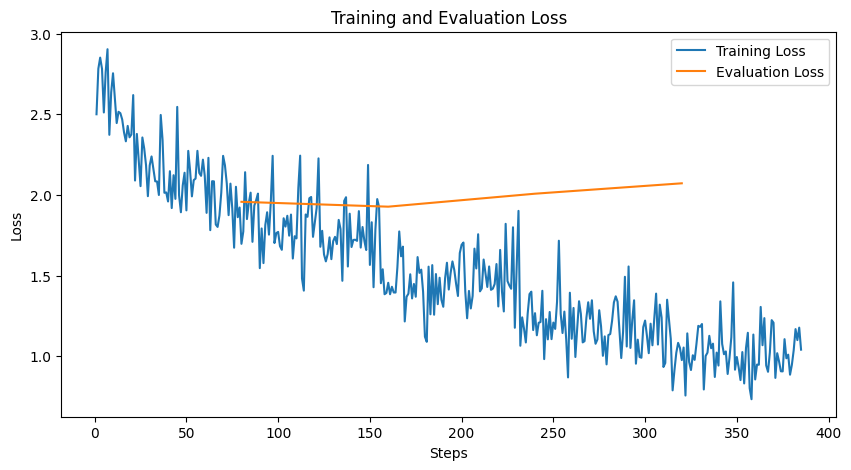

In [ ]:
import matplotlib.pyplot as plt

# After trainer.train()
log_history = trainer.state.log_history
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
steps = [log['step'] for log in log_history if 'loss' in log]
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Evaluation Loss")
plt.title("Training and Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
final_adapter_path = f"{output_dir}/final_model_adapters_combined_datasets"
trainer.model.save_pretrained(final_adapter_path) # Saves only the LoRA adapters
tokenizer.save_pretrained(final_adapter_path) # Save tokenizer with adapters
print(f"Final LoRA adapters saved to {final_adapter_path}")

# If you want to save the full merged model (optional, much larger):
# from peft import AutoPeftModelForCausalLM
# merged_model_path = f"{output_dir}/final_merged_model"
# # Load the PEFT model
# merged_model = AutoPeftModelForCausalLM.from_pretrained(
#     final_adapter_path, # path to the saved adapters
#     device_map="auto",
#     torch_dtype=torch.bfloat16 # or torch.float16
# )
# # Merge LoRA and base model
# merged_model = merged_model.merge_and_unload()
# merged_model.save_pretrained(merged_model_path, safe_serialization=True)
# tokenizer.save_pretrained(merged_model_path)
# print(f"Full merged model saved to {merged_model_path}")
# For inference, it's often easier to load the base model and then apply adapters.

Final LoRA adapters saved to ./llama3_sft_config_peft_fixed/final_model_adapters_combined_datasets


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Configuration for loading the base model
base_model_id = "meta-llama/Llama-3.2-1B-Instruct"
adapter_path = final_adapter_path # Or path to a specific checkpoint

# Load the base model (quantized or full precision, depending on how you want to run inference)
# For consistency with training and VRAM, using QLoRA for inference is common
bnb_config_inference = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

print(f"Loading base model: {base_model_id}")
base_model_for_inference = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config_inference, # or remove for full precision if VRAM allows
    device_map="auto",
    trust_remote_code=True,
)

print(f"Loading tokenizer from adapter path: {adapter_path}")
tokenizer_for_inference = AutoTokenizer.from_pretrained(adapter_path) # Load tokenizer saved with adapters

# Ensure pad_token is set on the tokenizer (critical for generation)
if tokenizer_for_inference.pad_token is None:
    print("Tokenizer pad_token is None, setting to eos_token.")
    tokenizer_for_inference.pad_token = tokenizer_for_inference.eos_token

# --- CRITICAL FIX: Update model's generation_config ---
# Ensure the model's config and generation_config have pad_token_id and eos_token_id
print(f"Setting pad_token_id ({tokenizer_for_inference.pad_token_id}) on model.config and model.generation_config")
base_model_for_inference.config.pad_token_id = tokenizer_for_inference.pad_token_id
base_model_for_inference.generation_config.pad_token_id = tokenizer_for_inference.pad_token_id

if tokenizer_for_inference.eos_token_id is None:
    print("ERROR: tokenizer_for_inference.eos_token_id is None! This should not happen.")
    # Handle error or set a default if absolutely necessary, though this indicates a problem with tokenizer loading.
else:
    print(f"Setting eos_token_id ({tokenizer_for_inference.eos_token_id}) on model.generation_config")
    base_model_for_inference.generation_config.eos_token_id = tokenizer_for_inference.eos_token_id
# --- END OF CRITICAL FIX ---

print(f"Loading PEFT adapters from: {adapter_path}")
inference_model = PeftModel.from_pretrained(base_model_for_inference, adapter_path)
inference_model.eval() # Set to evaluation mode
print("Inference model loaded successfully.")
print(f"  Inference model's generation_config.eos_token_id: {inference_model.generation_config.eos_token_id}")
print(f"  Inference model's generation_config.pad_token_id: {inference_model.generation_config.pad_token_id}")

Loading base model: meta-llama/Llama-3.2-1B-Instruct


/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1569: UserWarning: Current model requires 16.0 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading tokenizer from adapter path: ./llama3_sft_config_peft_fixed/final_model_adapters_combined_datasets
Setting pad_token_id (128009) on model.config and model.generation_config
Setting eos_token_id (128009) on model.generation_config
Loading PEFT adapters from: ./llama3_sft_config_peft_fixed/final_model_adapters_combined_datasets
Inference model loaded successfully.
  Inference model's generation_config.eos_token_id: 128009
  Inference model's generation_config.pad_token_id: 128009


/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1569: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


In [ ]:
def chat_with_human_model(conversation_history_str, max_new_tokens=150):
    # Ensure the prompt ends appropriately for the model to generate Human 2's response
    if not conversation_history_str.strip().endswith("Human 2:"):
         # If history is empty or ends with Human 2, start Human 1
        if not conversation_history_str.strip() or conversation_history_str.strip().endswith("Human 1:"):
             # This case should ideally not happen if we provide full history
             pass # Let it be, or add "Human 1: " if needed
        # If history ends with Human 1's turn, add "Human 2: "
        elif conversation_history_str.strip().endswith("Human 1:"):
             conversation_history_str += "\nHuman 2: " # This indicates model should generate Human 2's line
        # If history is complete, add new Human 1 prompt then Human 2:
        # This part is handled by how you build `current_conversation_for_prompt`

    # Add BOS token if not present (our training data has it)
    if not conversation_history_str.startswith(tokenizer_for_inference.bos_token):
        conversation_history_str = tokenizer_for_inference.bos_token + conversation_history_str

    inputs = tokenizer_for_inference(conversation_history_str, return_tensors="pt", padding=False, truncation=True).to(inference_model.device)
    
    # Remove token_type_ids if the model doesn't expect it (Llama generally doesn't)
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    # Define stopping conditions.
    # The primary EOS token is already set on inference_model.generation_config.eos_token_id.
    # Additional stopping sequences can be handled by passing their token IDs.
    # If "\nHuman 1:" is multi-token, this specific way of stopping might be inexact.
    # A custom StoppingCriteria class would be more robust for multi-token sequences.
    eos_token_ids_for_stopping = [tokenizer_for_inference.eos_token_id]
    # Optional: Try to stop if it starts generating a new "Human 1:" turn.
    # This requires "\nHuman 1:" to be a single token or for generate to handle multi-token sequences here.
    # Note: Llama 3 tokenizer might tokenize "\nHuman 1:" into multiple tokens.
    # For simplicity, we'll rely on the primary EOS and post-generation cleanup.
    # If you observe issues, a custom StoppingCriteria is the way to go for complex sequences.
    
    # Forcing early stop if it generates the token for "\n" followed by "Human 1:" can be tricky.
    # The simplest and most robust is often to rely on the main EOS and clean up after.
    # Let's use only the main EOS for generate, and clean up "\nHuman 1:" post-generation.

    with torch.no_grad(): # Disable gradient calculations for inference
        outputs = inference_model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens,
            num_return_sequences=1,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.9,
            #eos_token_id=eos_token_ids_for_stopping, # Relies on generation_config.eos_token_id being set
            pad_token_id=tokenizer_for_inference.pad_token_id # Already set on generation_config
                                                               # but can be confirmed here.
        )
    
    # Decode only the newly generated tokens
    response_ids = outputs[0][inputs.input_ids.shape[1]:]
    response_text = tokenizer_for_inference.decode(response_ids, skip_special_tokens=True)
    
    # Post-generation cleanup: Remove any partially generated "Human 1:" turn
    if "\nHuman 1:" in response_text:
        response_text = response_text.split("\nHuman 1:")[0]
    elif "Human 1:" in response_text: # If it somehow generates "Human 1:" without newline
        response_text = response_text.split("Human 1:")[0]
        
    return response_text.strip()


# --- Interactive Chat Loop ---
print("\n--- Starting Interactive Chat ---")
print("Type 'quit' to end the conversation.")
print("An empty input will also quit.")

# Initialize conversation history.
# For Llama 3, it's good practice to ensure the full prompt adheres to its expected format,
# even if we only explicitly add BOS here. The training data did not have system prompts.
current_conversation_log = "" 

while True:
    user_input = input("Human 1: ")
    if user_input.lower() == 'quit' or user_input == "":
        break
    
    # Append user's turn to the conversation log
    current_conversation_log += f"Human 1: {user_input}\n"
    
    # Prepare the full prompt for the model to generate Human 2's response
    # The chat_with_human_model function will prepend BOS if needed.
    prompt_for_model = current_conversation_log + "Human 2: "

    # Get model's response
    print("Human 2: Thinking...", end="\r") # Temporary "Thinking" message
    bot_response = chat_with_human_model(prompt_for_model)
    print(f"Human 2: {bot_response}       ") # Print response, overwrite "Thinking"
    
    # Append bot's turn to the conversation log
    current_conversation_log += f"Human 2: {bot_response}\n"

    # Optional: Truncate conversation_history_log if it gets too long to prevent exceeding max_seq_length significantly
    # (A more sophisticated approach would use a sliding window or summarize older parts)
    # For now, this simple loop lets it grow.

print("\n--- Chat Ended ---")



--- Starting Interactive Chat ---
Type 'quit' to end the conversation.
An empty input will also quit.



Human 1:  hi


In [ ]:
# --- Example Non-Interactive Test (Optional) ---
print("\n--- Running Non-Interactive Test ---")
test_history = "Human 1: hey whats up\nHuman 2: nm u\nHuman 1: tell me a joke\nHuman 2: "
response = chat_with_human_model(test_history)
print(f"Input:\n{test_history}")
print(f"Output:\n{response}")

ai_test_history = "Human 1: Are you an AI language model?\nHuman 2:"
response_ai_test = chat_with_human_model(ai_test_history)
print(f"\nInput:\n{ai_test_history}")
print(f"Output:\n{response_ai_test}")


--- Running Non-Interactive Test ---


KeyboardInterrupt: 

In [ ]:
while True:
    user_input = input("Human 1: ")
    if user_input.lower() == 'quit' or user_input == "":
        break
    
    # Append user's turn to the conversation log
    current_conversation_log += f"Human 1: {user_input}\n"
    
    # Prepare the full prompt for the model to generate Human 2's response
    # The chat_with_human_model function will prepend BOS if needed.
    prompt_for_model = current_conversation_log + "Human 2: "

    # Get model's response
    print("Human 2: Thinking...", end="\r") # Temporary "Thinking" message
    bot_response = chat_with_human_model(prompt_for_model)
    print(f"Human 2: {bot_response}       ") # Print response, overwrite "Thinking"
    
    # Append bot's turn to the conversation log
    current_conversation_log += f"Human 2: {bot_response}\n"

    # Optional: Truncate conversation_history_log if it gets too long to prevent exceeding max_seq_length significantly
    # (A more sophisticated approach would use a sliding window or summarize older parts)
    # For now, this simple loop lets it grow.

print("\n--- Chat Ended ---")